<a href="https://colab.research.google.com/github/Kishan-Kumar-Zalavadia/HackUNT_FraudDetection/blob/jeevan/Predicting_fraudulant_transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id='import'></a>
#### 1. Import

In [30]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [31]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
import zipfile
import pandas as pd

# Define the path to your zip file and the desired save path for the extracted CSV
zip_path = '/content/Fraud.csv.zip'
save_path = '/content/Fraud_extracted.csv'

# Open the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # List files in the zip archive
    file_list = zip_ref.namelist()

    # Assuming there's only one CSV file in the zip, get its name
    csv_filename = file_list[0]  # Replace 0 if there are multiple files or specify directly

    # Extract the CSV file and read it directly into a pandas DataFrame
    with zip_ref.open(csv_filename) as csv_file:
        df = pd.read_csv(csv_file)

# Save the DataFrame to a new CSV file
df.to_csv(save_path, index=False)

# Display the first few rows of the DataFrame to confirm
print(df.head())


In [ ]:
import numpy as np

# Load your data
df = pd.read_csv('/content/Fraud_extracted.csv')

# Define cities and probabilities for the 'location' column
cities = ["Denton", "Los Angeles", "Houston", "New York", "Miami", "Las Vegas", "San Francisco", "Boston", "Seattle"]
probabilities = [0.85] + [0.15 / (len(cities) - 1)] * (len(cities) - 1)

# Generate the 'location' column with 85% entries as 'Denton' and 15% as other cities
df['location'] = np.random.choice(cities, size=len(df), p=probabilities)

# Update 'isFlaggedFraud' to 1 when location is not 'Denton' and 'amount' is greater than 5000
df['isFlaggedFraud'] = np.where(
    (df['location'] != 'Denton') | ((df['type'] == 'debit') & (df['amount'] > 5000)),
    1,
    df['isFlaggedFraud']
)

# Save the modified DataFrame to a new file
df.to_csv('/content/Fraudulant_Data_with_location.csv', index=False)

# Display the first few rows to confirm
print(df.head())


Import data and correct spelling of original column headers for consistency

In [32]:
df = pd.read_csv('/content/Fraudulant_Data_with_location.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

Test if there any missing values in DataFrame. It turns out there are no
obvious missing values but, as we will see below, this does not rule out proxies by a numerical
value like 0.

In [33]:
df.isnull().values.any()

False

<a id='fraud-trans'></a>
##### 2.1. Which types of transactions are fraudulent?
We find that of the five types of transactions, fraud occurs only in two of them (see also kernels by <a href='https://www.kaggle.com/netzone/eda-and-fraud-detection'>Net</a>, <a href='https://www.kaggle.com/philschmidt/where-s-the-money-lebowski'>Philipp Schmidt</a> and <a href='https://www.kaggle.com/ibenoriaki/three-features-with-kneighbors-auc-score-is-0-998'>Ibe_Noriaki</a>):
'TRANSFER' where money is sent to a customer / fraudster
and 'CASH_OUT' where money is sent to a merchant who pays the customer /
fraudster
in cash. Remarkably, the number of
fraudulent TRANSFERs almost equals the number of fraudulent CASH_OUTs (see the right half of the plot in section <a href='#time'>5.1</a>). These
observations appear, at first, to bear out
the description provided on Kaggle for the modus operandi of fraudulent
transactions in
this dataset, namely, fraud is committed by first transferring out funds
to another account which subsequently cashes it out. We will return to this issue later in section <a href='#common-accounts'>2.4</a>

In [34]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values)))


dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]
dfFraudDebit = df.loc[(df.isFraud == 1) & (df.type == 'DEBIT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer)))

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout)))

print ('\n The number of fraudulent DEBITs = {}'.\
       format(len(dfFraudDebit)))


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116

 The number of fraudulent DEBITs = 0


<a id='clean'></a>
#### Data cleaning

From the exploratory data analysis (EDA) of section <a href='#EDA#'>2</a>, we know that fraud only occurs in
'TRANSFER's and 'CASH_OUT's. So we assemble only the corresponding data in X
for analysis.

In [35]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

#X = X.loc[np.random.choice(X.index, 100000, replace = False)]

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

In [36]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


In [37]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = - 1

In [38]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan

<a id='feature-eng'></a>
#### 4. Feature-engineering

Motivated by the possibility of zero-balances serving to differentiate between
fraudulent and genuine transactions, we take the data-imputation of section <a href='#imputation'>3.1</a> a
step further and create 2 new features (columns) recording errors in the
originating and
destination accounts for each transaction. These new features turn out to be
important in obtaining the best performance from the ML algorithm that we will
finally use.

In [39]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

<a id='visualization'></a>
#### 5. Data visualization

<a id='time'></a>
##### 5. 1. Dispersion over time

<a id='amount'></a>
##### Dispersion over amount

In [41]:
# limit = len(X)
# ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
#               figsize = (14, 9))
# ax.set_ylabel('- errorBalanceDest', size = 16)
# ax.set_title('Opposite polarity fingerprints over the error in \
# destination account balances', size = 18);

<a id='ML'></a>
#### 6. Machine Learning to Detect Fraud in Skewed Data

In [43]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)

In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import LabelEncoder

# Assuming X is your feature DataFrame and Y is your target variable (labels)

# Your existing preprocessing code
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0),
      ['oldBalanceDest', 'newBalanceDest']] = -1
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0),
      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan

X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

# Adding the 'location' column as a feature (assuming 'location' already exists in your DataFrame)
# If 'location' is categorical, we will need to encode it
if 'location' in X.columns:
    le = LabelEncoder()
    X['location'] = le.fit_transform(X['location'])

# Print skew of the dataset
print('skew = {}'.format(len(Xfraud) / float(len(X))))

# Split the data into training and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=randomState)

# Define and train the Random Forest Classifier
weights = (trainY == 0).sum() / (1.0 * (trainY == 1).sum())  # Adjust for class imbalance
clf = RandomForestClassifier(max_depth=3, class_weight={0: 1, 1: weights}, n_jobs=4)

# Fit the model and make predictions
clf.fit(trainX, trainY)
probabilities = clf.predict_proba(testX)

# Calculate and print AUPRC
print('AUPRC = {}'.format(average_precision_score(testY, probabilities[:, 1])))


skew = 0.002964544224336551
AUPRC = 0.9969698256554944


In [54]:
import pickle

# Save the model using pickle
model_filename = 'Fraudulant_detection.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(clf, file)

print(f'Model saved to {model_filename}')

Model saved to Fraudulant_detection.pkl


<a id='importance'></a>
##### 6.1. What are the important features for the ML model?
The figure below shows that the new feature *errorBalanceOrig* that we created is the most relevant feature for the model. The features are ordered based on the number of samples affected by splits on those features.

<ipython-input-47-266ccf237d96>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(importance_df['Feature'], size=12)


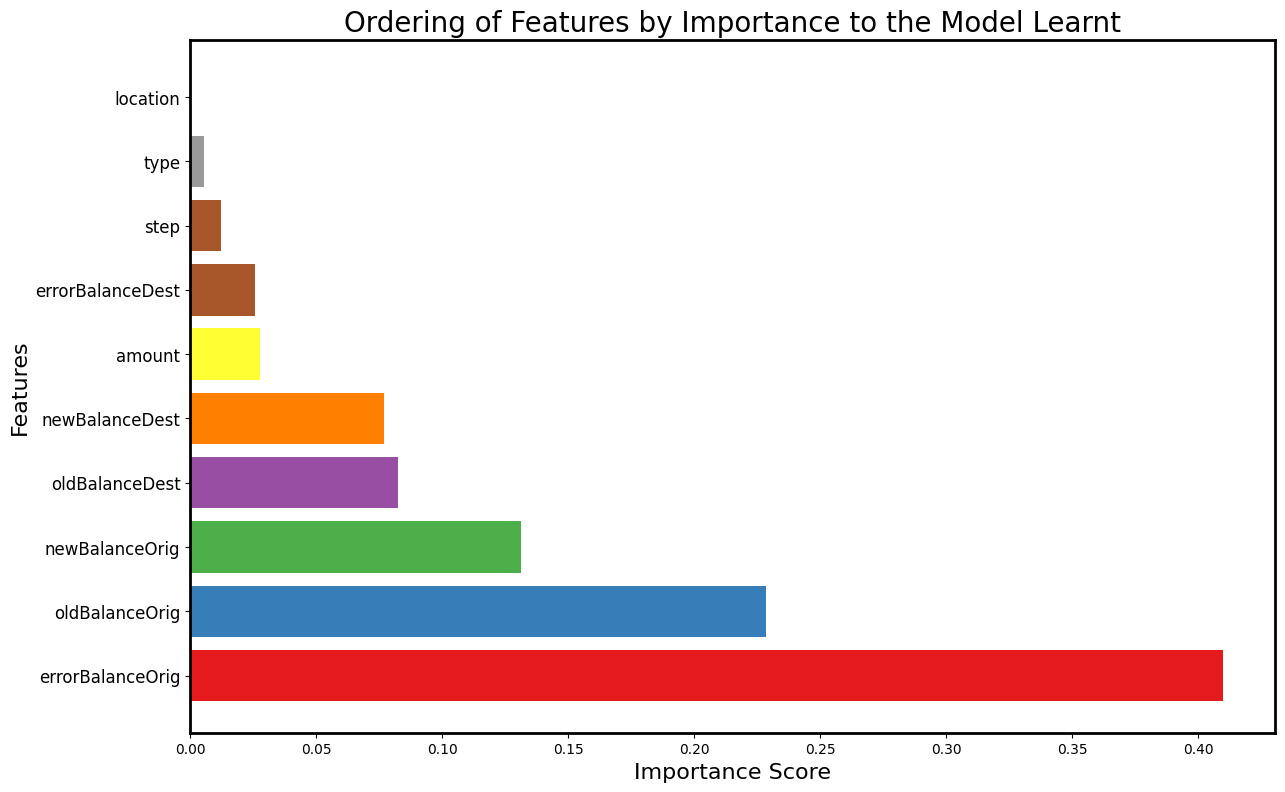

In [47]:
# Calculate feature importances
importances = clf.feature_importances_
feature_names = X.columns  # Get feature names

# Create a DataFrame for easier plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111)

# Create a horizontal bar plot
ax.barh(importance_df['Feature'], importance_df['Importance'], color=plt.cm.Set1(np.linspace(0, 1, len(importance_df))))

# Customize the plot
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)

ax.set_xlabel('Importance Score', size=16)
ax.set_ylabel('Features', size=16)
ax.set_yticklabels(importance_df['Feature'], size=12)
ax.set_title('Ordering of Features by Importance to the Model Learnt', size=20)

plt.show()

<a id='decision-tree'></a>
##### 6.2. Visualization of ML model
The root node
in the decision tree visualized below is indeed
the feature *errorBalanceOrig*,
as would be expected from its high significance to the
model.

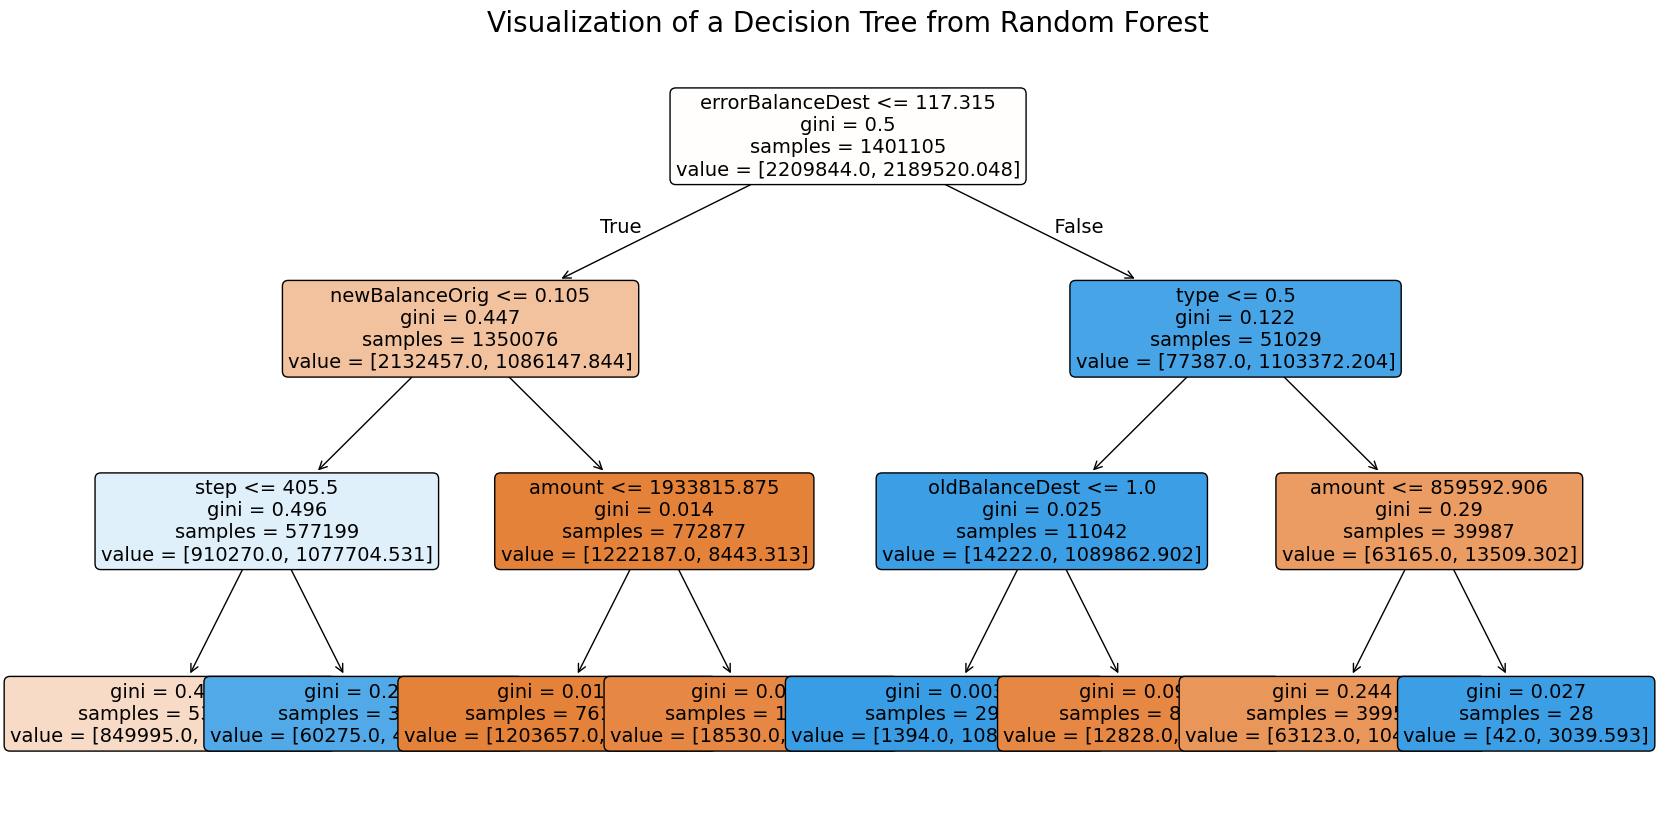

In [50]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Select one tree from the random forest (e.g., the first tree)
estimator = clf.estimators_[0]  # Get the first tree in the forest

# Create a plot for the tree
plt.figure(figsize=(20, 10))
plot_tree(estimator, filled=True, feature_names=X.columns, rounded=True, fontsize=14)
plt.title('Visualization of a Decision Tree from Random Forest', size=20)
plt.show()

<a id='learning-curve'></a>
##### 6.3. Bias-variance tradeoff

Benefits of Learning Curves with Random Forest

1) Model Diagnosis: Just as with XGBoost, learning curves for Random Forest help diagnose model performance. They allow you to see if your model is underfitting or overfitting.

2) Data Requirements: They provide insight into whether additional training data might improve model performance.

3) Parameter Tuning: You can use the curves to inform decisions about the depth of trees or the number of trees in the forest, potentially leading to a better-tuned model.



In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve

# Assuming you have trainX and trainY defined, along with weights for class imbalance
trainSizes, trainScores, crossValScores = learning_curve(
    RandomForestClassifier(max_depth=3, n_jobs=4),  # Replace XGBClassifier with RandomForestClassifier
    trainX,
    trainY,
    scoring='average_precision'
)

# Calculate means and standard deviations
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

# Visualization
colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize=(14, 9))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
                 trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
                 crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScoresMean, 'o-', label='train', color=colours[0])
plt.plot(trainSizes, crossValScoresMean, 'o-', label='cross-val', color=colours[1])

# Customizing the plot
ax = plt.gca()
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15),
           loc=2, borderaxespad=0, fontsize=16)
plt.xlabel('Training Set Size', size=16)
plt.ylabel('AUPRC', size=16)
plt.title('Learning Curves for Random Forest Classifier', size=20)

plt.show()


KeyboardInterrupt: 